In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\angon\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Conducción de calor en una placa plana 1D. 

Uno de los problemas más simples que se puede modelar es la distribución de temperatura en una placa plana. Este sistema está gobernado por la ecuación de calor en 1D:

$$ -k\frac{d^2T}{dx^2} - q = 0 $$

En esta ecuación $k$ es la conductividad térmica, $T$ la temperatura, $x$ la posición espacial y $q$ la tasa de generación de calor en el material.  

Esta ecuación es muy simple de solucionar de manera analítica. Sin embargo, a manera de ejemplo implementaremos un algoritmo para la solución de esta solución mediante el método de los elementos finitos.  

Para completar la definición del problema se establece el dominio del mismo para $0 < x < L$ con una condición de frontera esencial en $x=0$

$T(0) = g \\textrm{ - condición esencial}$  
$\frac{dT(L)}{dx} = h \\textrm{ - condición natural}$  




In [6]:
def basis(x,i,dx):
    """Returns the ith basis funciton at x
    x-position
    i - basis funciton index
    dx - width of each element
    """
    if x <= (i-1)*dx: return 0.0
    if x >= (i+1)*dx: return 0.0
    if x < i*dx: return (x-i*dx)/dx+1
    return 1.0-(x-i*dx)/dx

def dbasis(x,i,dx):
    """Returns the ith basis funciton at x
    x-position
    i - basis funciton index
    dx - width of each element
    """
    if x <= (i-1)*dx: return 0.0
    if x >= (i+1)*dx: return 0.0
    if x < i*dx: return 1.0/dx
    return -1.0/dx

In [7]:
def f(x):
    return 1.0

In [8]:
n = 4
dx = 1.0/n
g = 1.0 # u(0) = g
h = 0.0 # u'(1) = h

In [9]:
K = np.zeros((n+1,n+1))

for A in range(n+1): # loop over basis A
    for B in range(n+1): # loop over basis B
        for e in range(n): # loop over elements
            xmid = 0.5*(e*dx+(e+1)*dx)
            dNa = dbasis(xmid,A,dx)
            dNb = dbasis(xmid,B,dx)
            K[A,B] += dNa*dNb*dx


In [10]:
F = np.zeros((n+1))
for A in range(n+1):
    for e in range(n):
        xmid = 0.5*(e*dx+(e+1)*dx)
        Na = basis(xmid,A,dx)
        F[A] += Na*f(xmid)*dx

In [12]:
ibc = 0
F -= K[:,ibc]*g
K[:,ibc] = K[ibc,:] = 0
K[ibc,ibc] = 1
F[ibc] = g

# Add Neumann condition
F[n] += h

In [13]:
# Solve
d = np.linalg.solve(K,F)

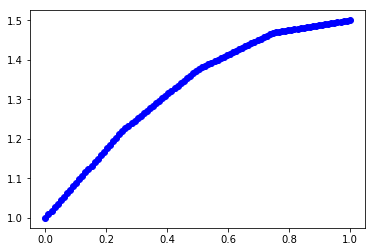

In [14]:
# Plot solution
x = np.linspace(0,1,100)
for y in x:
    val = 0.
    for i in range (n+1):
        val += basis(y,i,dx)*d[i]
    plt.plot(y,val,'bo')
plt.show()